In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from geopy import distance as gdist # Use geopy for measuring distances between pairs of coordinates https://geopy.readthedocs.io/en/stable/#module-geopy.distance
from sklearn import preprocessing
import datetime

from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

weather_weather = pd.DataFrame()


avg_weather_days = 21
weather_lag_days = datetime.timedelta(days=12)

In [2]:
# reading the data sets

data = pd.read_csv('/home/jack/Dropbox/2019_unsw/t2/comp9417/assignment/west_nile/input/train.csv',dtype = str)

spray = pd.read_csv('/home/jack/Dropbox/2019_unsw/t2/comp9417/assignment/west_nile/input/spray.csv')

weather = pd.read_csv('/home/jack/Dropbox/2019_unsw/t2/comp9417/assignment/west_nile/input/weather.csv')

test_data = pd.read_csv('/home/jack/Dropbox/2019_unsw/t2/comp9417/assignment/west_nile/input/test.csv', dtype = str)

# importing the pre-computed data of the spraying effect instead of calculation above

data_modified = pd.read_csv('/home/jack/Dropbox/2019_unsw/t2/comp9417/assignment/west_nile/input/train_modified.csv')

data_modified.loc[data_modified['Spray']==1, ].head()

print('Number of affected samples by spraying:', data_modified.loc[data_modified['Spray']==1, ].shape[0])

print('Total number of samples: ', data.shape[0])

print('Percent of samplings affected by spraying: ', round(data_modified.loc[data_modified['Spray']==1, ].shape[0]/data.shape[0], 2), '%')

#Separate the stations

weather_st1 = weather[weather["Station"] == 1].reset_index()

weather_st2 = weather[weather["Station"] == 2].reset_index()

# Now we want to find the closest station to each trap (this does not account for traps that have been moved, does address accuracy change after they have been moved?):
# Apparently they are only moved a couple of km so it probably doesnt matter.
closest_station_train = {}
for i in data_modified["Trap"].unique():
    lat = data_modified["Latitude"][data_modified["Trap"] == i].iloc[0]
    lon = data_modified["Longitude"][data_modified["Trap"] == i].iloc[0]
    if gdist.distance((lat,lon),(41.995, -87.933)) < gdist.distance((lat,lon),(41.786, -87.752)):
#        print("Station 1 is closer to Trap: " + str(i))
        closest_station_train[i] = 1
    else:
#        print("Station 2 is closer to Trap: " + str(i))
        closest_station_train[i] = 2
        

data_modified["Station"] = pd.DataFrame([[closest_station_train[i]] for i in data_modified["Trap"]])

Number of affected samples by spraying: 179
Total number of samples:  10506
Percent of samplings affected by spraying:  0.02 %


In [3]:
#Getting the unique locations that have at some point tested positive for WNV
#----------------------------------------------------------------------------------

# Perhaps do this again but sum the number of times a location has tested positive!

#----------------------------------------------------------------------------------

wnv_locations = (data[data["WnvPresent"]=='1'])[["Latitude","Longitude"]]

wnv_locations.drop_duplicates(inplace = True)


temp_df = data[['Latitude','Longitude']].merge(wnv_locations.drop_duplicates(), on=['Latitude','Longitude'], 

                   how='left', indicator=True)


non_wnv_locations = (temp_df[temp_df['_merge'] == 'left_only'])[['Latitude','Longitude']]

non_wnv_locations.drop_duplicates(inplace = True)

#len(non_wnv_locations)

wnv_locations["WnvPresent"] = 1

# The claim is that 99 unique traps got WNV at some point

non_wnv_locations["WnvPresent"] = 0

# The claim is 39 traps have never had WNV

unique_locations = pd.concat([wnv_locations,non_wnv_locations])

unique_locations = (unique_locations.reset_index())[["Latitude","Longitude","WnvPresent"]]



In [4]:
# Create binary history for the training data
dicto={}

def f(lat, lon, unq_loc):
    dicto_key = lat+lon

    if dicto_key not in dicto:
        smallest = min([(gdist.distance((np.float128(lat), \
                                         np.float128(lon)), \
                                        (np.float128(unq_lat),np.float128(unq_lon))), \
                                        unq_wnv) \
                        for unq_lat, unq_lon, unq_wnv \
                        in zip(unq_loc['Latitude'], \
                               unq_loc['Longitude'], \
                               unq_loc['WnvPresent'])])
        
        dicto[dicto_key] = smallest[1]

    return dicto[dicto_key]

result_train = [f(lat, lon, unique_locations) for lat, lon in zip(data['Latitude'],data['Longitude'])]

In [5]:
# Now do the same for the test data:
# We can use the same dictionary from before

def f(lat, lon, unq_loc):
    dicto_key = lat+lon

    if dicto_key not in dicto:
        smallest = min([(gdist.distance((np.float128(lat), \
                                         np.float128(lon)), \
                                        (np.float128(unq_lat),np.float128(unq_lon))), \
                                        unq_wnv) \
                        for unq_lat, unq_lon, unq_wnv \
                        in zip(unq_loc['Latitude'], \
                               unq_loc['Longitude'], \
                               unq_loc['WnvPresent'])])
        
        dicto[dicto_key] = smallest[1]

    return dicto[dicto_key]

result_test = [f(lat, lon, unique_locations) for lat, lon in zip(test_data['Latitude'],test_data['Longitude'])]

In [6]:
# Doing it for the training data is easy:

wnv_locations = (data[data["WnvPresent"]=='1'])[["Latitude","Longitude"]]
#print(len(wnv_locations))
wnv_locations = pd.DataFrame(wnv_locations.groupby(["Latitude","Longitude"]).size().reset_index())

wnv_locations.columns = ["Latitude","Longitude",'WnvSumHist']

# Now need to perform some kind of join with the training data
# such that it duplicates these values and fills the rest with zeros

left = data[["Latitude",'Longitude']]

train_out = pd.merge(left, wnv_locations, how='left', on=['Latitude', 'Longitude'])

train_out = train_out.fillna(0);

non_wnv_locations.columns = ['Latitude','Longitude','WnvSumHist']

unique_locations = pd.concat([wnv_locations,non_wnv_locations])

#unique_locations



In [7]:
# Doing it for the test data is a bit harder as we need to find the closest trap
# let us join wnv_locations with 

dicto = {}

def f(lat, lon, unq_loc):
    dicto_key = lat+lon

    if dicto_key not in dicto:
        smallest = min([(gdist.distance((np.float128(lat), \
                                         np.float128(lon)), \
                                        (np.float128(unq_lat),np.float128(unq_lon))), \
                                        unq_wnv) \
                        for unq_lat, unq_lon, unq_wnv \
                        in zip(unq_loc['Latitude'], \
                               unq_loc['Longitude'], \
                               unq_loc['WnvSumHist'])])
        
        dicto[dicto_key] = smallest[1]

    return dicto[dicto_key]

test_out = [f(lat, lon, unique_locations) for lat, lon in zip(test_data['Latitude'],test_data['Longitude'])]


In [8]:
data['NumMosquitos'] = pd.to_numeric(data['NumMosquitos'])
NumMosqHist = data.groupby(['Latitude','Longitude'])['NumMosquitos'].sum().reset_index()
NumMosqHist.columns = ['Latitude','Longitude','NumMosqHist']

train_NumMosqHist = pd.merge(data, NumMosqHist, how='left', on=['Latitude', 'Longitude'])

In [9]:
# Again we now have to do this for the test data by finding the nearest neighbours:

dicto = {}

def f(lat, lon, NumMosqHist):
    dicto_key = lat+lon

    if dicto_key not in dicto:
        smallest = min([(gdist.distance((np.float128(lat), \
                                         np.float128(lon)), \
                                        (np.float128(unq_lat),np.float128(unq_lon))), \
                                        unq_MosqHist) \
                        for unq_lat, unq_lon, unq_MosqHist \
                        in zip(NumMosqHist['Latitude'], \
                               NumMosqHist['Longitude'], \
                               NumMosqHist['NumMosqHist'])])
        
        dicto[dicto_key] = smallest[1]

    return dicto[dicto_key]

test_NumMosqHist = [f(lat, lon, NumMosqHist) for lat, \
                    lon in zip(test_data['Latitude'],test_data['Longitude'])]



In [10]:
data_modified['WnvBinaryHist'] = result_train
data_modified['WnvSumHist'] = train_out['WnvSumHist']
data_modified['NumMosqHist']=train_NumMosqHist['NumMosqHist']

# Now that we have avoided strange floating point errors using
# strings, lets reimport the test data but now allow floats
test_data = pd.read_csv('/home/jack/Dropbox/2019_unsw/t2/comp9417/assignment/west_nile/input/test.csv')
test_data['WnvBinaryHist'] = result_test
test_data['WnvSumHist'] = test_out
test_data['NumMosqHist'] = test_NumMosqHist

#Get the nearest weather station for the test data
closest_station_test = {}
for i in test_data["Trap"].unique():
    lat = test_data["Latitude"][test_data["Trap"] == i].iloc[0]
    lon = test_data["Longitude"][test_data["Trap"] == i].iloc[0]
    if gdist.distance((lat,lon),(41.995, -87.933)) < gdist.distance((lat,lon),(41.786, -87.752)):
#        print("Station 1 is closer to Trap: " + str(i))
        closest_station_test[i] = 1
    else:
#        print("Station 2 is closer to Trap: " + str(i))
        closest_station_test[i] = 2

test_data["Station"] = pd.DataFrame([[closest_station_test[i]] for i in test_data["Trap"]])



#Fill missing heat and cool with data from station 1
weather_st2.loc[weather_st2["Heat"] == 'M',["Heat"]] = weather_st1["Heat"][weather_st2["Heat"] == 'M']
weather_st2.loc[weather_st2["Cool"] == 'M',["Cool"]] = weather_st1["Cool"][weather_st2["Cool"] == 'M']

#Data missing from weather_st2 "Tavg" a good approximation is give it the Tavg value from Station 1
weather_st2.loc[weather_st2["Tavg"] == 'M',["Tavg"]] = weather_st1["Tavg"][weather_st2["Tavg"] == 'M']

# Both sets of WetBulb data have missing values:
# The missing dates do not overlap so we can substitute in eachothers WetBulb measurements:

weather_st2.loc[weather_st2["WetBulb"] == 'M',["WetBulb"]] = weather_st1["WetBulb"][weather_st2["WetBulb"] == 'M']
weather_st1.loc[weather_st1["WetBulb"] == 'M',["WetBulb"]] = weather_st2["WetBulb"][weather_st1["WetBulb"] == 'M']

# Two values missing for precip total from weathe St2, so replace with St1's precip

weather_st2.loc[weather_st2["PrecipTotal"] == 'M',["PrecipTotal"]] = weather_st1["PrecipTotal"][weather_st2["PrecipTotal"] == 'M']

#Also there exis "T" for "trace amounts of rain" We will set this to zero:

#weather_st2["PrecipTotal"][weather_st2["PrecipTotal"] == 'T'] = 0
weather_st2.loc[weather_st2["PrecipTotal"] == 'T',["PrecipTotal"]] = 0

#weather_st1["PrecipTotal"][weather_st1["PrecipTotal"] == 'T'] = 0
weather_st1.loc[weather_st1["PrecipTotal"] == 'T',["PrecipTotal"]] = 0

#weather_st2["PrecipTotal"][weather_st2["PrecipTotal"] == ' T'] = 0
weather_st2.loc[weather_st2["PrecipTotal"] == ' T',["PrecipTotal"]] = 0

#weather_st1["PrecipTotal"][weather_st1["PrecipTotal"] == ' T'] = 0
weather_st1.loc[weather_st1["PrecipTotal"] == ' T',["PrecipTotal"]] = 0

#weather_st2["PrecipTotal"][weather_st2["PrecipTotal"] == '  T'] = 0
weather_st2.loc[weather_st2["PrecipTotal"] == '  T',["PrecipTotal"]] = 0

#weather_st1["PrecipTotal"][weather_st1["PrecipTotal"] == '  T'] = 0
weather_st1.loc[weather_st1["PrecipTotal"] == '  T',["PrecipTotal"]] = 0

#Missing station pressure data overlap at one data point
# So take the average of either side:
weather_st1.loc[1205, ('StnPressure')]=str((float(weather_st1["StnPressure"][1204])+float(weather_st1["StnPressure"][1206]))/2)
weather_st2.loc[1205, ('StnPressure')]=str((float(weather_st2["StnPressure"][1204])+float(weather_st2["StnPressure"][1206]))/2)

#Then fix the non-overlapping missing data points:
weather_st2.loc[weather_st2["StnPressure"] == 'M',["StnPressure"]] = weather_st1["StnPressure"][weather_st2["StnPressure"] == 'M']
weather_st1.loc[weather_st1["StnPressure"] == 'M',["StnPressure"]] = weather_st2["StnPressure"][weather_st1["StnPressure"] == 'M']

#now for windspeed, station 2 is missing data, fill it in with station 1 data:
weather_st2.loc[weather_st2["AvgSpeed"] == 'M',["AvgSpeed"]] = weather_st1["AvgSpeed"][weather_st2["AvgSpeed"] == 'M']

#station 2 doesn't track sunrise or sunset so copy over station 1's values

weather_st2["Sunrise"]=weather_st1["Sunrise"]
weather_st2["Sunset"]=weather_st1["Sunset"]



In [11]:
def avg_and_delay(av,de):
    avg_weather_days = av
    weather_lag_days = datetime.timedelta(days=de)
    
    
    avg_weather_st1 = weather_st1.copy()
    avg_weather_st2 = weather_st2.copy()
    avg_weather_st1["Date"] = avg_weather_st1["Date"]
    avg_weather_st2["Date"] = avg_weather_st2["Date"]
    avg_weather_st1["Tmax"] = avg_weather_st1["Tmax"].rolling(avg_weather_days).max() #instead of average maximum chose max of the maximums
    avg_weather_st2["Tmax"] = avg_weather_st2["Tmax"].rolling(avg_weather_days).max()
    avg_weather_st1["Tmin"] = avg_weather_st1["Tmin"].rolling(avg_weather_days).min() #instead of average minimum chose min of the minumums
    avg_weather_st2["Tmin"] = avg_weather_st2["Tmin"].rolling(avg_weather_days).min()
    avg_weather_st1["Tavg"] = avg_weather_st1["Tavg"].rolling(avg_weather_days).mean() #Used average of the average temperatures
    avg_weather_st1["Heat"] = avg_weather_st1["Heat"].rolling(avg_weather_days).sum() #using the sum because these values are normally tallied
    avg_weather_st2["Heat"] = avg_weather_st2["Heat"].rolling(avg_weather_days).sum()
    avg_weather_st1["Cool"] = avg_weather_st1["Cool"].rolling(avg_weather_days).sum() #using the sum because these values are normally tallied
    avg_weather_st2["Cool"] = avg_weather_st2["Cool"].rolling(avg_weather_days).sum() #using the sum because these values are normally tallied
    avg_weather_st2["Tavg"] = avg_weather_st2["Tavg"].rolling(avg_weather_days).mean() #Used average of the average temperatures after fixing missing values
    avg_weather_st1["DewPoint"] = avg_weather_st1["DewPoint"].rolling(avg_weather_days).mean()
    avg_weather_st2["DewPoint"] = avg_weather_st2["DewPoint"].rolling(avg_weather_days).mean()

    avg_weather_st1["WetBulb"] = avg_weather_st1["WetBulb"].rolling(avg_weather_days).mean()
    avg_weather_st2["WetBulb"] = avg_weather_st2["WetBulb"].rolling(avg_weather_days).mean()

    avg_weather_st1["PrecipTotal"] = avg_weather_st1["PrecipTotal"].rolling(avg_weather_days).sum() #using the sum instead of the mean because that makes more sense for rainfall
    avg_weather_st2["PrecipTotal"] = avg_weather_st2["PrecipTotal"].rolling(avg_weather_days).sum()

    avg_weather_st1["StnPressure"] = avg_weather_st1["StnPressure"].rolling(avg_weather_days).mean()
    avg_weather_st2["StnPressure"] = avg_weather_st2["StnPressure"].rolling(avg_weather_days).mean()


    avg_weather_st1["AvgSpeed"] = avg_weather_st1["AvgSpeed"].rolling(avg_weather_days).mean()
    avg_weather_st2["AvgSpeed"] = avg_weather_st2["AvgSpeed"].rolling(avg_weather_days).mean()


#    avg_weather_st1["Sunrise"] = weather_st1["Sunrise"].rolling(avg_weather_days).mean()
#    avg_weather_st2["Sunrise"] = weather_st2["Sunrise"].rolling(avg_weather_days).mean()
#    avg_weather_st1["Sunset"] = weather_st1["Sunset"].rolling(avg_weather_days).mean()
#    avg_weather_st2["Sunset"] = weather_st2["Sunset"].rolling(avg_weather_days).mean()

    avg_weather_st1["ResultDir"] = avg_weather_st1["ResultDir"].rolling(avg_weather_days).mean()
    avg_weather_st2["ResultDir"] = avg_weather_st2["ResultDir"].rolling(avg_weather_days).mean()
    avg_weather_st1["ResultSpeed"] = avg_weather_st1["ResultSpeed"].rolling(avg_weather_days).mean()
    avg_weather_st2["ResultSpeed"] = avg_weather_st2["ResultSpeed"].rolling(avg_weather_days).mean()

    avg_weather_st1["Station"] = 1
    avg_weather_st2["Station"] = 2
    avg_weather = pd.concat([avg_weather_st1,avg_weather_st2],sort=True)

    # Now just need to join the averaged weather data with the main data based on both closest station and the weather_lag_days
    #shift the average weather date by weather_lag_days to ensure it will match with the correct collection data

    avg_weather.loc[:,"Date"] = (pd.DataFrame([(weather_lag_days + datetime.date(int(i[:4]),int(i[5:7]),int(i[8:10]))).isoformat() for i in avg_weather["Date"]]))[0]

    # Then add a continuous date variable (it is just the number of days into the year)
    avg_weather["DateCont"] = pd.DataFrame([datetime.date(int(i[:4]),int(i[5:7]),int(i[8:10])).toordinal()- datetime.date(int(i[:4]),1,1).toordinal() for i in avg_weather["Date"]])
    
    
    # Scale Weather
    scaler = preprocessing.StandardScaler()


    avg_weather[['Tmax','Tmin', 'Tavg',\
                 'DewPoint','WetBulb',\
                 'Heat','Cool','PrecipTotal',\
                 'StnPressure','ResultSpeed',\
                 'ResultDir','AvgSpeed',\
                 'DateCont']] = scaler.fit_transform(avg_weather[['Tmax','Tmin', 'Tavg',\
                                                                  'DewPoint','WetBulb',\
                                                                  'Heat','Cool','PrecipTotal',\
                                                                  'StnPressure','ResultSpeed',\
                                                                  'ResultDir','AvgSpeed',\
                                                                  'DateCont']])

    avg_weather = avg_weather[['Date','Station','Tmax','Tmin', 'Tavg',\
                 'DewPoint','WetBulb','Heat','Cool','PrecipTotal',\
                 'StnPressure','ResultSpeed','ResultDir','AvgSpeed',\
                 'DateCont']]

# Hopefully fix NA in weather when doing long averages    
    
    avg_weather[["DewPoint", 'Tavg',\
                          'WetBulb',\
                          'StnPressure',\
                          'AvgSpeed',\
                          'ResultDir','ResultSpeed']] = avg_weather[["DewPoint",\
                                                                     'Tavg','WetBulb',\
                                                                     'StnPressure',\
                                                                     'AvgSpeed',\
                                                                     'ResultDir',\
                                                                     'ResultSpeed']].fillna(avg_weather.iloc[av-1:2*av-1].mean()) 

    avg_weather[["Tmax"]] = avg_weather[["Tmax"]].fillna(avg_weather.iloc[av-1:2*av-1].max())
    
    avg_weather[["Tmin"]] = avg_weather[["Tmin"]].fillna(avg_weather.iloc[av-1:2*av-1].min())
   
    avg_weather[["Heat","Cool","PrecipTotal"]] = avg_weather[["Heat","Cool","PrecipTotal"]].fillna(avg_weather.iloc[av-1:2*av-1].max())    
    
    
  
        
    train_data_processed = pd.merge(data_modified,avg_weather,on=["Date","Station"])    
    test_data_processed = pd.merge(test_data,avg_weather,on=["Date","Station"])
    
    del test_data_processed["Block"]
    del test_data_processed["Address"]
    del test_data_processed["AddressNumberAndStreet"]
    del test_data_processed["AddressAccuracy"]
    del test_data_processed["Station"]
    del test_data_processed["Street"]
    del test_data_processed["Trap"]

    del train_data_processed["Block"]
    del train_data_processed["Address"]
    del train_data_processed["AddressNumberAndStreet"]
    del train_data_processed["AddressAccuracy"]
    del train_data_processed["Station"]
    del train_data_processed["Street"]
    del train_data_processed["Trap"]

    train_data_processed = train_data_processed[train_data_processed["Spray"] == 0]
    del train_data_processed["Spray"]

    del train_data_processed["Date"]
    del test_data_processed["Date"]
    del train_data_processed["NumMosquitos"]
    
    # One Hot encoding of the species data
    train_data_processed['Species'] = pd.Categorical(train_data_processed['Species'])
    train_data_processed_Dummies = pd.get_dummies(train_data_processed['Species'], prefix = 'Species')
    train_data_processed = pd.concat([train_data_processed, train_data_processed_Dummies], axis=1)
    train_data_processed['Species_UNSPECIFIED CULEX'] = 1
    del train_data_processed['Species']


    test_data_processed['Species'] = pd.Categorical(test_data_processed['Species'])
    test_data_processed_Dummies = pd.get_dummies(test_data_processed['Species'], prefix = 'Species')
    test_data_processed = pd.concat([test_data_processed, test_data_processed_Dummies], axis=1)
    del test_data_processed['Species']

    # Scale coordinates and WnvSumHist and NumMosqHist
    geo_scaler = preprocessing.StandardScaler()

    train_data_processed[['Longitude','Latitude','WnvSumHist','NumMosqHist']] = geo_scaler.fit_transform(train_data_processed[['Longitude','Latitude','WnvSumHist','NumMosqHist']])

    test_data_processed[['Longitude','Latitude','WnvSumHist','NumMosqHist']] = geo_scaler.transform(test_data_processed[['Longitude','Latitude','WnvSumHist','NumMosqHist']])    
    
    return (train_data_processed,test_data_processed)


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import ShuffleSplit
#cv = ShuffleSplit(n_splits=10, test_size=0.3)
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier as xgb

mean_scores = []
av_de = []

for av in range(1,92,4):
    for de in range(0,40,3):
        print("DELAY = " + str(de))
        print("AVERAGE = " +str(av)+" days")
        train_data_processed = (avg_and_delay(av,de))[0]
        runs = 20
        summ = 0
        print("RandOver - Decision Tree")
        for i in range(runs):

            imb_data = train_data_processed.copy()
            imb_train, imb_test = train_test_split(imb_data)
            imb_train_SMOTE_x = imb_train
            imb_train_SMOTE_y = imb_train["WnvPresent"].copy()
            del imb_train_SMOTE_x["WnvPresent"]

            imb_test_x = imb_test
            imb_test_y = imb_test["WnvPresent"].copy()
            del imb_test_x["WnvPresent"]

            sm = RandomOverSampler()
            imb_train_SMOTE_x, imb_train_SMOTE_y = sm.fit_sample(imb_train_SMOTE_x, imb_train_SMOTE_y)
            dt = DecisionTreeClassifier(max_depth = 8)
            dt.fit(imb_train_SMOTE_x, imb_train_SMOTE_y)

            predicts = dt.predict_proba(imb_test_x)

            summ+= roc_auc_score(imb_test_y,predicts[:,1])
        print(summ/runs)
        dtree_mean = summ/runs
        print('\n')
        
        summ = 0

        print("SMOTE - Logistic Regression")
        for i in range(runs):
            

            imb_data = train_data_processed.copy()
            imb_train, imb_test = train_test_split(imb_data)
            imb_train_SMOTE_x = imb_train
            imb_train_SMOTE_y = imb_train["WnvPresent"].copy()
            del imb_train_SMOTE_x["WnvPresent"]

            imb_test_x = imb_test
            imb_test_y = imb_test["WnvPresent"].copy()
            del imb_test_x["WnvPresent"]

            sm = SMOTE(kind = 'regular')
            imb_train_SMOTE_x, imb_train_SMOTE_y = sm.fit_sample(imb_train_SMOTE_x, imb_train_SMOTE_y)
            logreg = LogisticRegression(solver='liblinear')
            logreg.fit(imb_train_SMOTE_x, imb_train_SMOTE_y)

            predicts = logreg.predict_proba(imb_test_x)
            summ+= roc_auc_score(imb_test_y,predicts[:,1])
        print(summ/runs)
        logreg_mean = summ/runs
        print('\n')
        
        print('XGB:')
        cv = ShuffleSplit(n_splits=10,test_size=0.3)

        xgb_data_x = train_data_processed.copy()
        xgb_data_y = xgb_data_x["WnvPresent"]
        del xgb_data_x["WnvPresent"]

        scores = cross_val_score(xgb(), xgb_data_x, xgb_data_y, cv=cv, scoring='roc_auc')
        print('mean: ' + str(sum(scores)/len(scores)))
        print('max: ' + str(max(scores)))
        print('min: ' + str(min(scores)))        
        xgb_mean = sum(scores)/len(scores)
        print('------------------------------------------------\n')
        mean_scores.append((dtree_mean,logreg_mean,xgb_mean))
        av_de.append((av,de))

DELAY = 0
AVERAGE = 1 days
RandOver - Decision Tree
0.798228170135544


SMOTE - Logistic Regression
0.76903702805587


XGB:
mean: 0.8505011713031762
max: 0.8697852379337628
min: 0.8307404891304349
------------------------------------------------

DELAY = 3
AVERAGE = 1 days
RandOver - Decision Tree
0.7893351541014038


SMOTE - Logistic Regression
0.785866288101394


XGB:
mean: 0.8566852603074935
max: 0.8766718849910702
min: 0.8380137545485647
------------------------------------------------

DELAY = 6
AVERAGE = 1 days
RandOver - Decision Tree
0.8023597638608164


SMOTE - Logistic Regression
0.7768843392938158


XGB:
mean: 0.8599959279046223
max: 0.8733927098054913
min: 0.850148119926601
------------------------------------------------

DELAY = 9
AVERAGE = 1 days
RandOver - Decision Tree
0.7967118365288142


SMOTE - Logistic Regression
0.7848264696243921


XGB:
mean: 0.8568682835811898
max: 0.8739568044968774
min: 0.8304180028339175
------------------------------------------------

DELAY

RandOver - Decision Tree
0.798946980534716


SMOTE - Logistic Regression
0.7879944933134952


XGB:
mean: 0.8515946527532716
max: 0.8664422837682332
min: 0.8352745880084151
------------------------------------------------

DELAY = 18
AVERAGE = 9 days
RandOver - Decision Tree
0.8085163177155579


SMOTE - Logistic Regression
0.7942549190828007


XGB:
mean: 0.853416104276423
max: 0.8659702167782197
min: 0.8259539218995057
------------------------------------------------

DELAY = 21
AVERAGE = 9 days
RandOver - Decision Tree
0.7982800867556766


SMOTE - Logistic Regression
0.8003640593018526


XGB:
mean: 0.8595950323880232
max: 0.8769297153173634
min: 0.8464503042596349
------------------------------------------------

DELAY = 24
AVERAGE = 9 days
RandOver - Decision Tree
0.8016454558473608


SMOTE - Logistic Regression
0.8320215150534412


XGB:
mean: 0.8594153503855351
max: 0.8770946750595441
min: 0.8331323866200833
------------------------------------------------

DELAY = 27
AVERAGE = 9 day

RandOver - Decision Tree
0.796123540866554


SMOTE - Logistic Regression
0.8113496406074463


XGB:
mean: 0.8630439394020047
max: 0.8792702011527158
min: 0.853036506311839
------------------------------------------------

DELAY = 33
AVERAGE = 17 days
RandOver - Decision Tree
0.797880256390681


SMOTE - Logistic Regression
0.803692454883995


XGB:
mean: 0.8546848821773836
max: 0.8689418537708693
min: 0.8439994080916778
------------------------------------------------

DELAY = 36
AVERAGE = 17 days
RandOver - Decision Tree
0.7954808662086925


SMOTE - Logistic Regression
0.8179035530613442


XGB:
mean: 0.8577972530159823
max: 0.8656652331494104
min: 0.8442589272777993
------------------------------------------------

DELAY = 39
AVERAGE = 17 days
RandOver - Decision Tree
0.7973921470573692


SMOTE - Logistic Regression
0.8200579584902048


XGB:
mean: 0.8575869719311797
max: 0.8743539403666657
min: 0.8419048146280053
------------------------------------------------

DELAY = 0
AVERAGE = 21 da

RandOver - Decision Tree
0.7947522833024366


SMOTE - Logistic Regression
0.8285343997624122


XGB:
mean: 0.8605418541266502
max: 0.8741128627799806
min: 0.8498552009214858
------------------------------------------------

DELAY = 6
AVERAGE = 29 days
RandOver - Decision Tree
0.7973531554525828


SMOTE - Logistic Regression
0.8264428385571871


XGB:
mean: 0.863976655279675
max: 0.8829128194595752
min: 0.8413634971979287
------------------------------------------------

DELAY = 9
AVERAGE = 29 days
RandOver - Decision Tree
0.807457168920705


SMOTE - Logistic Regression
0.8210320456519564


XGB:
mean: 0.8589565988267076
max: 0.8706138236325386
min: 0.8400463225681702
------------------------------------------------

DELAY = 12
AVERAGE = 29 days
RandOver - Decision Tree
0.7947029970115035


SMOTE - Logistic Regression
0.8140666363613207


XGB:
mean: 0.8619733989861749
max: 0.8797421908946073
min: 0.8344642105179523
------------------------------------------------

DELAY = 15
AVERAGE = 29 d

RandOver - Decision Tree
0.7997555306602955


SMOTE - Logistic Regression
0.8203271812277391


XGB:
mean: 0.8644528647602966
max: 0.8819482509187956
min: 0.8454943465949029
------------------------------------------------

DELAY = 21
AVERAGE = 37 days
RandOver - Decision Tree
0.7998980283272835


SMOTE - Logistic Regression
0.8241058568249848


XGB:
mean: 0.8691263562299885
max: 0.8875805044251466
min: 0.8546801620377569
------------------------------------------------

DELAY = 24
AVERAGE = 37 days
RandOver - Decision Tree
0.808735339651031


SMOTE - Logistic Regression
0.840991841691263


XGB:
mean: 0.8655325541638226
max: 0.8888789588898038
min: 0.8540968356038918
------------------------------------------------

DELAY = 27
AVERAGE = 37 days
RandOver - Decision Tree
0.797893867251964


SMOTE - Logistic Regression
0.8358099874989205


XGB:
mean: 0.8616901840524094
max: 0.88375833615915
min: 0.8486038974529437
------------------------------------------------

DELAY = 30
AVERAGE = 37 da

RandOver - Decision Tree
0.7942920739949914


SMOTE - Logistic Regression
0.8285331308524988


XGB:
mean: 0.864098163362786
max: 0.8757751822679487
min: 0.8327928388746804
------------------------------------------------

DELAY = 36
AVERAGE = 45 days
RandOver - Decision Tree
0.7968396954928172


SMOTE - Logistic Regression
0.8295255311296851


XGB:
mean: 0.8484198654602061
max: 0.8644165956826199
min: 0.8320880215658697
------------------------------------------------

DELAY = 39
AVERAGE = 45 days
RandOver - Decision Tree
0.7940443464443121


SMOTE - Logistic Regression
0.818018164734046


XGB:
mean: 0.8498000466994557
max: 0.8701190897299846
min: 0.8339753149575577
------------------------------------------------

DELAY = 0
AVERAGE = 49 days
RandOver - Decision Tree
0.7960643607517741


SMOTE - Logistic Regression
0.827725318067049


XGB:
mean: 0.8612223781206376
max: 0.874712485951018
min: 0.8501192359313585
------------------------------------------------

DELAY = 3
AVERAGE = 49 day

RandOver - Decision Tree
0.8062468285847301


SMOTE - Logistic Regression
0.8371761623821582


XGB:
mean: 0.8632642195465683
max: 0.885912811006444
min: 0.8468318839997591
------------------------------------------------

DELAY = 9
AVERAGE = 57 days
RandOver - Decision Tree
0.805815868169149


SMOTE - Logistic Regression
0.8382653946396956


XGB:
mean: 0.8661331720392983
max: 0.8764323363693277
min: 0.8564496650084826
------------------------------------------------

DELAY = 12
AVERAGE = 57 days
RandOver - Decision Tree
0.8064338867058621


SMOTE - Logistic Regression
0.8323389689689416


XGB:
mean: 0.8623289936949636
max: 0.8843985001912593
min: 0.8446200243746256
------------------------------------------------

DELAY = 15
AVERAGE = 57 days
RandOver - Decision Tree
0.8070448570848369


SMOTE - Logistic Regression
0.8324183608635993


XGB:
mean: 0.860296102738286
max: 0.8797969585495109
min: 0.8388842078269392
------------------------------------------------

DELAY = 18
AVERAGE = 57 d

RandOver - Decision Tree
0.8011269584587799


SMOTE - Logistic Regression
0.8278125291858931


XGB:
mean: 0.8634181732193189
max: 0.887419435669716
min: 0.8524210686095932
------------------------------------------------

DELAY = 24
AVERAGE = 65 days
RandOver - Decision Tree
0.799216164770605


SMOTE - Logistic Regression
0.8349142870349417


XGB:
mean: 0.8691876693792062
max: 0.8868098573756067
min: 0.8535332517854366
------------------------------------------------

DELAY = 27
AVERAGE = 65 days
RandOver - Decision Tree
0.8004103653297084


SMOTE - Logistic Regression
0.8434557645317262


XGB:
mean: 0.8631302845774016
max: 0.8845871563605502
min: 0.8508924030147501
------------------------------------------------

DELAY = 30
AVERAGE = 65 days
RandOver - Decision Tree
0.795591187424313


SMOTE - Logistic Regression
0.8366210091706625


XGB:
mean: 0.8621570129320378
max: 0.8851422759733798
min: 0.8363823933975241
------------------------------------------------

DELAY = 33
AVERAGE = 65 

RandOver - Decision Tree
0.7910654171257182


SMOTE - Logistic Regression
0.8212594874165438


XGB:
mean: 0.8528582807389394
max: 0.8727287413592265
min: 0.832312487941627
------------------------------------------------

DELAY = 39
AVERAGE = 73 days
RandOver - Decision Tree
0.7987032139555512


SMOTE - Logistic Regression
0.8099117510790054


XGB:
mean: 0.8559708726247426
max: 0.8748243458769774
min: 0.8441116115329522
------------------------------------------------

DELAY = 0
AVERAGE = 77 days
RandOver - Decision Tree
0.8001176317015493


SMOTE - Logistic Regression
0.840435389282133


XGB:
mean: 0.8624655133452531
max: 0.8769912410419748
min: 0.8427565623325936
------------------------------------------------

DELAY = 3
AVERAGE = 77 days
RandOver - Decision Tree
0.8044336525986738


SMOTE - Logistic Regression
0.8300062166827168


XGB:
mean: 0.8646664107231062
max: 0.877988532014792
min: 0.8559081253319171
------------------------------------------------

DELAY = 6
AVERAGE = 77 day

RandOver - Decision Tree
0.8068465386999648


SMOTE - Logistic Regression
0.8282068686914099


XGB:
mean: 0.8685040060215765
max: 0.8776982871568721
min: 0.8431210151268909
------------------------------------------------

DELAY = 12
AVERAGE = 85 days
RandOver - Decision Tree
0.8041152052439913


SMOTE - Logistic Regression
0.8301179823881102


XGB:
mean: 0.8668180248941424
max: 0.8782380668403982
min: 0.8525885151977537
------------------------------------------------

DELAY = 15
AVERAGE = 85 days
RandOver - Decision Tree
0.8010085418231909


SMOTE - Logistic Regression
0.8333176540048692


XGB:
mean: 0.8710746140926066
max: 0.8827607875994973
min: 0.8613615622597783
------------------------------------------------

DELAY = 18
AVERAGE = 85 days
RandOver - Decision Tree
0.8056217271419985


SMOTE - Logistic Regression
0.8341517332923274


XGB:
mean: 0.8678631892768859
max: 0.8876114116939804
min: 0.846745529512932
------------------------------------------------

DELAY = 21
AVERAGE = 8

In [13]:
#import pickle
#pickle.dump(av_de, open( "av_de_31-av.pkl", "wb" ) )
#pickle.dump(mean_scores, open( "mean_scores.pkl", "wb" ) )

<IPython.core.display.Javascript object>


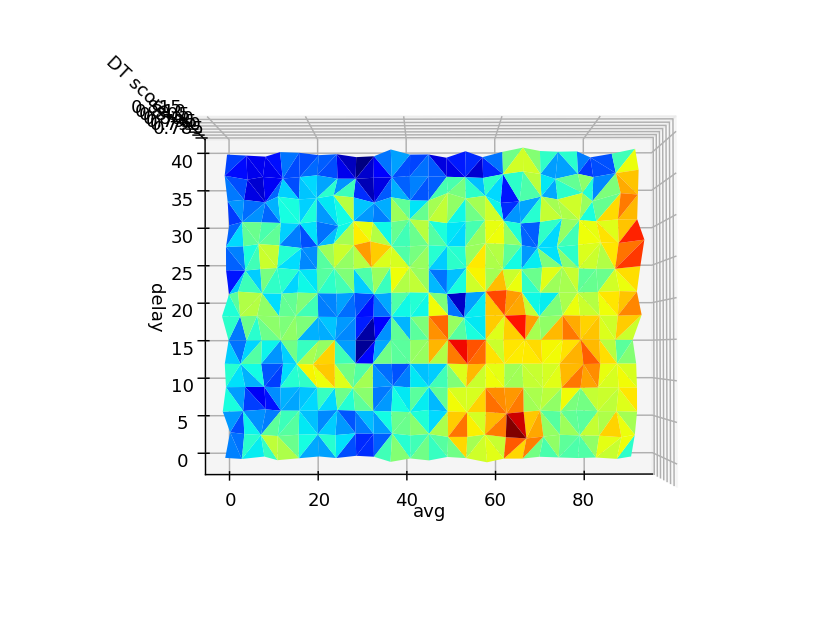

In [24]:
%matplotlib notebook
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf([i[0] for i in av_de], [i[1] for i in av_de], [i[0] for i in mean_scores], cmap=cm.jet, linewidth=0.2)
ax.set_xlabel('avg')
ax.set_ylabel('delay')
ax.set_zlabel('DT score')
plt.show()

<IPython.core.display.Javascript object>


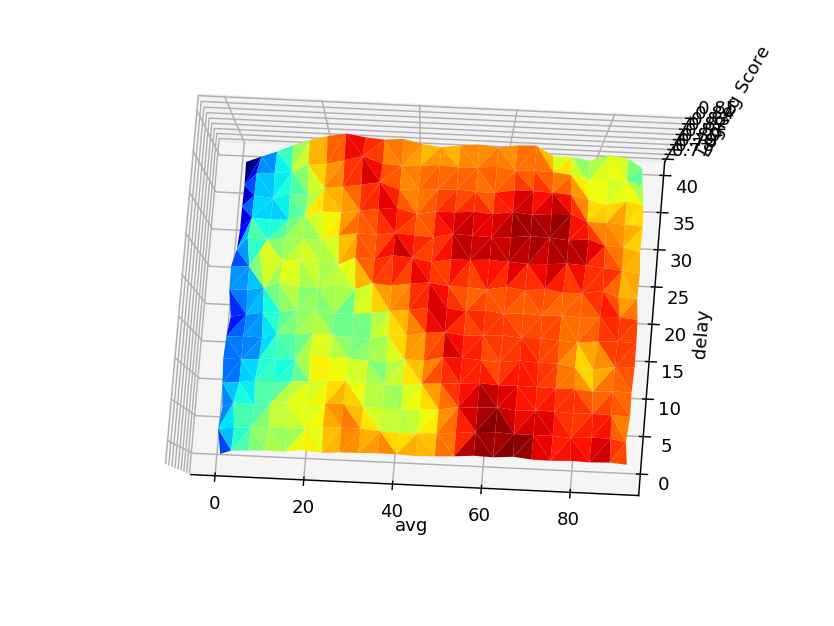

In [25]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf([i[0] for i in av_de], [i[1] for i in av_de], [i[1] for i in mean_scores], cmap=cm.jet, linewidth=0.2)
ax.set_xlabel('avg')
ax.set_ylabel('delay')
ax.set_zlabel('LogReg Score')
plt.show()

<IPython.core.display.Javascript object>


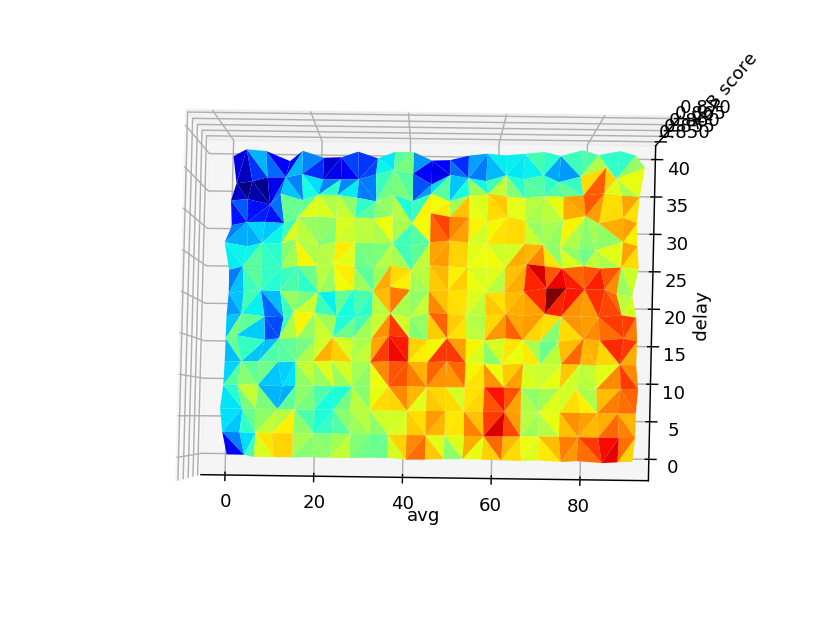

In [26]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf([i[0] for i in av_de], [i[1] for i in av_de], [i[2] for i in mean_scores], cmap=cm.jet, linewidth=0.2)
ax.set_xlabel('avg')
ax.set_ylabel('delay')
ax.set_zlabel('XGB score')
plt.show()

In [ ]:
type(weather_weather)